# Traffic Sign Classification
## 207 Applied Machine Learning, Final Project

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import copy


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

DATA_PATH = "./traffic_data"

In [ ]:
# Load images function
def load_data(path_to_data, directory):
    labels = []
    images = []

    if directory == "test":
        for file in os.listdir(os.path.join(path_to_data, directory)):
            image_path = os.path.join(path_to_data, directory, file)
            image = load_img(image_path)
            img_arr = img_to_array(image, dtype=int)
            images.append(img_arr)
            if file.split("_")[0] == "000":
                labels.append(0)
            else:
                labels.append(int(file.split("_")[0].lstrip("0")))
    else:
        path_to_data = os.path.join(path_to_data, directory)
        folders = sorted(os.listdir(path_to_data))
        if '.DS_Store' in folders:
            folders.remove('.DS_Store')
        for folder in folders:
            for file in os.listdir(os.path.join(path_to_data, folder)):
                image_path = os.path.join(path_to_data, folder, file)
                image = load_img(image_path)
                img_arr = img_to_array(image, dtype=int)
                images.append(img_arr)
                labels.append(int(folder))

    labels = np.array(labels, dtype=int)

    return images, labels



## Preliminary EDA

In [ ]:
# Load label names
label_names = pd.read_csv(os.path.join(DATA_PATH, "labels.csv"))

# Load training images and labels
train_images, train_labels = load_data(DATA_PATH, "train")

# Load test images and labels
test_images, test_labels = load_data(DATA_PATH, "test")

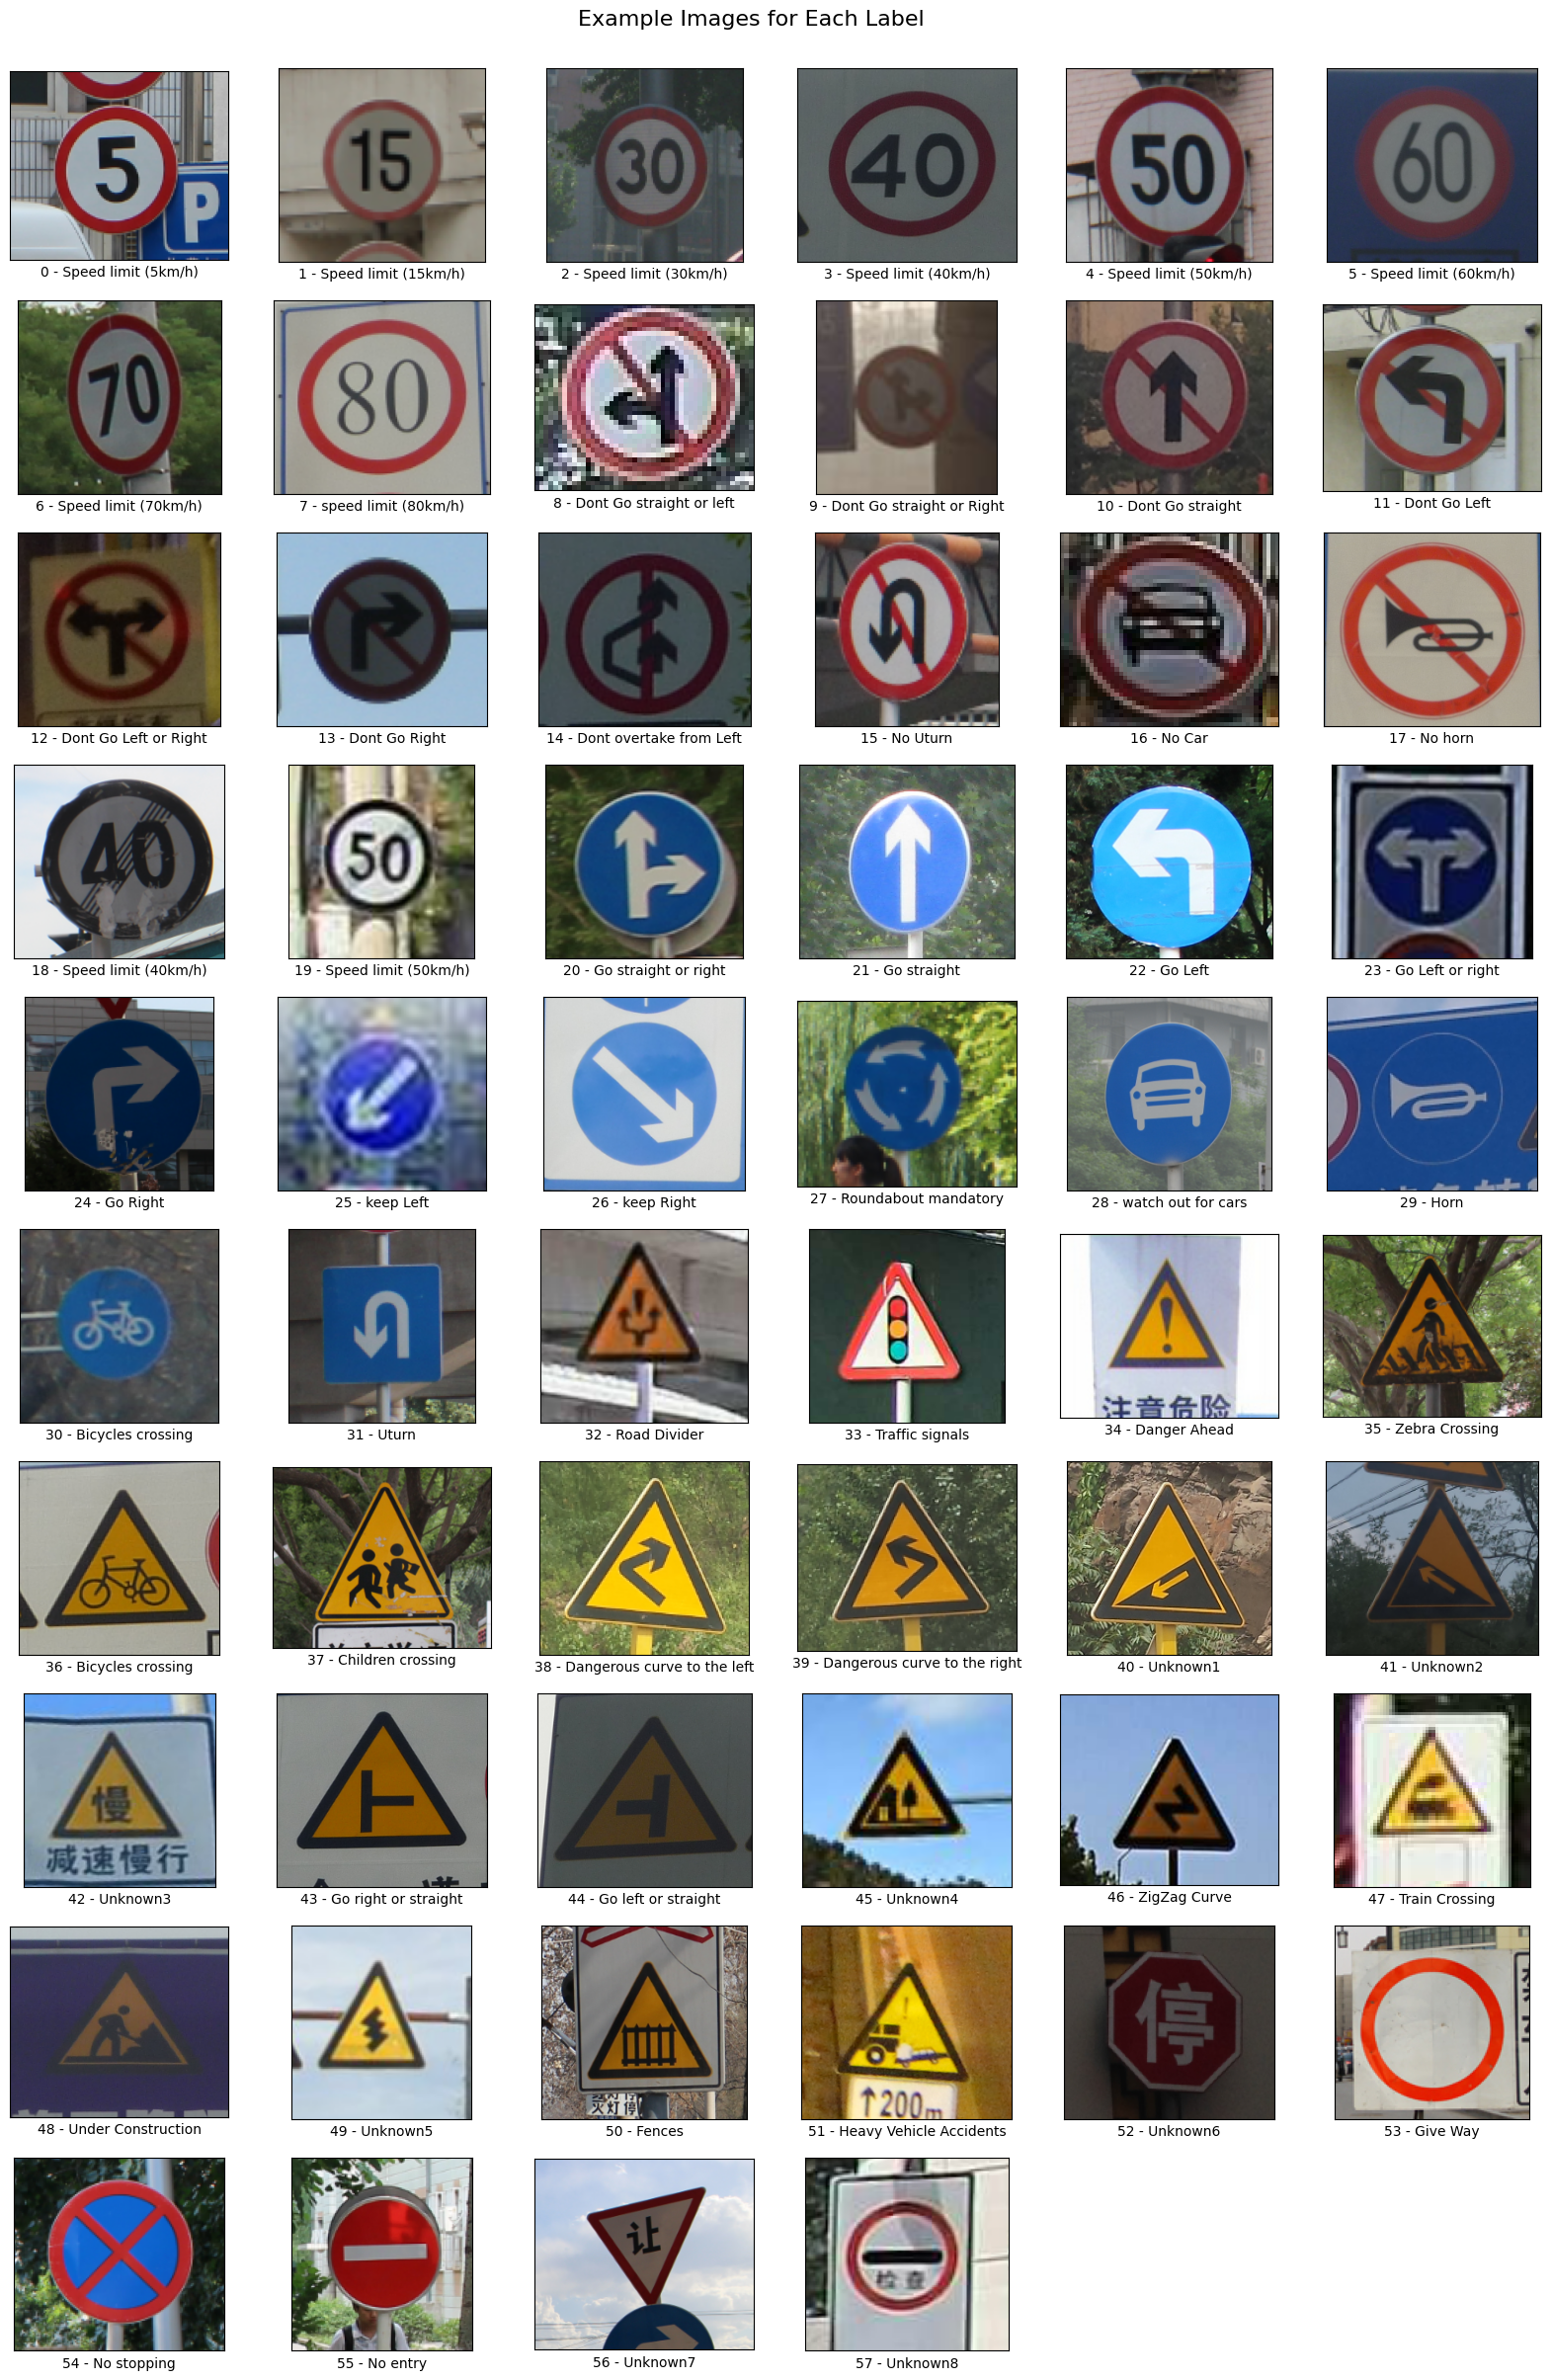

In [ ]:
# Display one image for each class
fig, axes = plt.subplots(10, 6, figsize=(20, 30))
fig.suptitle('Example Images for Each Label', fontsize=16, y=0.90)

unique, indices = np.unique(train_labels, return_index=True)

pics = []
for idx, num in enumerate(indices):
    pics.append(train_images[num])

for i, ax in enumerate(axes.flat):
    if i < 58:
        ax.imshow(pics[i])
        ax.tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            left=False,
            labelbottom=False,
            labelleft=False,
            grid_alpha=0)
        ax.set_xlabel(str(unique[i]) + " - " + label_names.iloc[i]['Name'])
    else:
        ax.axis('off')


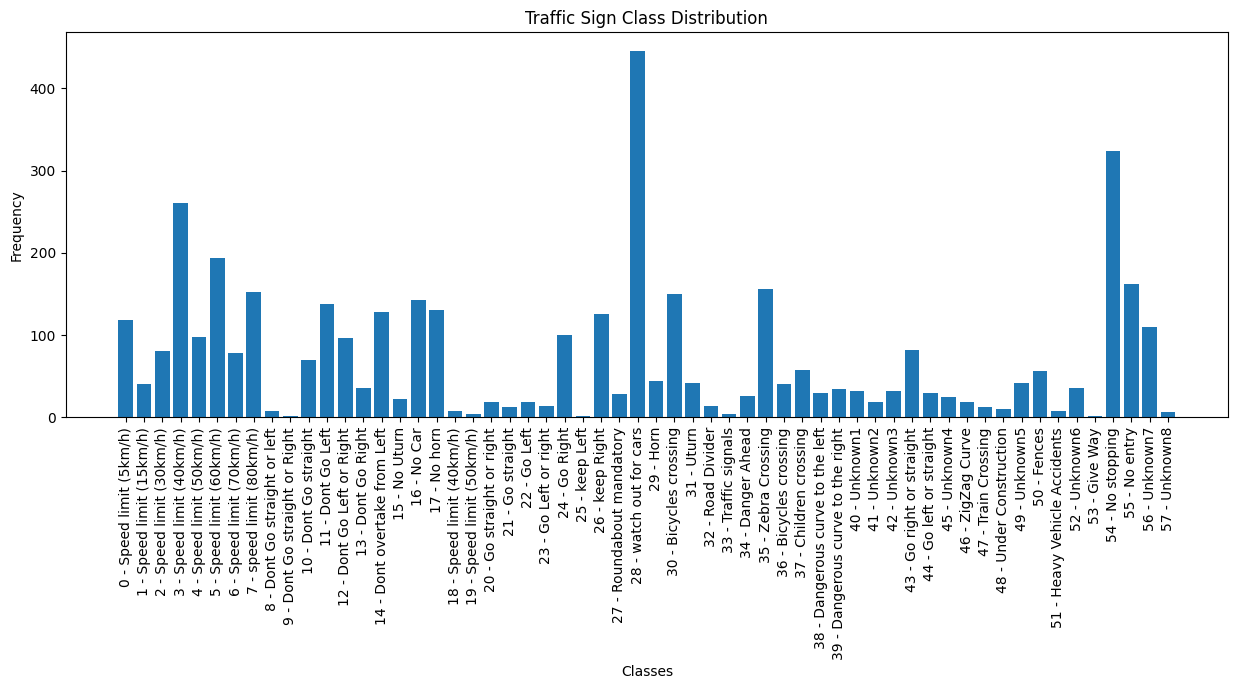

In [ ]:
# Find unique value counts
unique, counts = np.unique(train_labels, return_counts=True)
classes = [str(num) + " - " + label_names.iloc[num]['Name'] for num in unique]

# Create plot
plt.figure(figsize = (15, 5))
plt.bar(range(len(counts)), counts)

# Label/title plot
plt.title("Traffic Sign Class Distribution")
plt.xlabel("Classes")
plt.xticks(np.arange(len(counts)), classes, fontsize=10, rotation=90)
plt.ylabel("Frequency")

# Render plot
plt.show()

## Class aggregation

In [ ]:
# class aggregation function
def reassign_class(label):
    if label < 8 or 18 <= label < 20:
        return 0
    if 8 <= label < 18:
        return 1
    if 20 <= label <= 31:
        return 2
    if 32 <= label < 52:
        return 3
    if label >= 52:
        return 1

aggregated_labels = {0: "speed limit", 1: "prohibitive", 2: "indicative", 3: "warning"}

# update label_names data frame
label_names = label_names.assign(aggregated_class_id = label_names['ClassId'].map(reassign_class))
label_names = label_names.assign(aggregated_name = label_names['aggregated_class_id'].map(aggregated_labels))
display(label_names)

# update training labels
update = np.frompyfunc(reassign_class, 1, 1)
train_labels = update(train_labels)

# update test labels
test_labels = update(test_labels)


ClassId                          Name  aggregated_class_id aggregated_name
0         0           Speed limit (5km/h)                    0     speed limit
1         1          Speed limit (15km/h)                    0     speed limit
2         2          Speed limit (30km/h)                    0     speed limit
3         3          Speed limit (40km/h)                    0     speed limit
4         4          Speed limit (50km/h)                    0     speed limit
5         5          Speed limit (60km/h)                    0     speed limit
6         6          Speed limit (70km/h)                    0     speed limit
7         7          speed limit (80km/h)                    0     speed limit
8         8      Dont Go straight or left                    1     prohibitive
9         9     Dont Go straight or Right                    1     prohibitive
10       10              Dont Go straight                    1     prohibitive
11       11                  Dont Go Left                    1     prohibitive
12       12         Dont Go Left or Right                    1     prohibitive
13       13                 Dont Go Right                    1     prohibitive
14       14       Dont overtake from Left                    1     prohibitive
15       15                      No Uturn                    1     prohibitive
16       16                        No Car                    1     prohibitive
17       17                       No horn                    1     prohibitive
18       18          Speed limit (40km/h)                    0     speed limit
19       19          Speed limit (50km/h)                    0     speed limit
20       20          Go straight or right                    2      indicative
21       21                   Go straight                    2      indicative
22       22                       Go Left                    2      indicative
23       23              Go Left or right                    2      indicative
24       24                      Go Right                    2      indicative
25       25                     keep Left                    2      indicative
26       26                    keep Right                    2      indicative
27       27          Roundabout mandatory                    2      indicative
28       28            watch out for cars                    2      indicative
29       29                          Horn                    2      indicative
30       30             Bicycles crossing                    2      indicative
31       31                         Uturn                    2      indicative
32       32                  Road Divider                    3         warning
33       33               Traffic signals                    3         warning
34       34                  Danger Ahead                    3         warning
35       35                Zebra Crossing                    3         warning
36       36             Bicycles crossing                    3         warning
37       37             Children crossing                    3         warning
38       38   Dangerous curve to the left                    3         warning
39       39  Dangerous curve to the right                    3         warning
40       40                      Unknown1                    3         warning
41       41                      Unknown2                    3         warning
42       42                      Unknown3                    3         warning
43       43          Go right or straight                    3         warning
44       44           Go left or straight                    3         warning
45       45                      Unknown4                    3         warning
46       46                  ZigZag Curve                    3         warning
47       47                Train Crossing                    3         warning
48       48            Under Construction                    3         warning
49       49                      Unknown5             

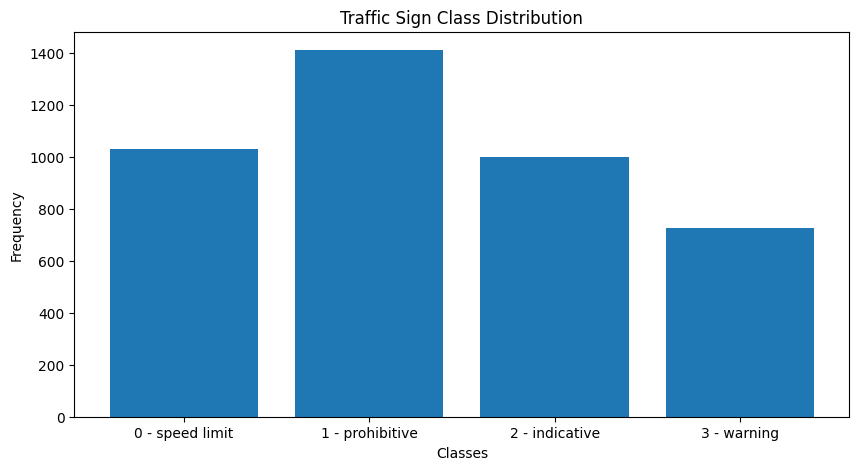

In [ ]:
# Find unique value counts
unique, counts = np.unique(train_labels, return_counts=True)
classes = [str(num) + " - " + aggregated_labels[num] for num in unique]

# Create plot
plt.figure(figsize = (10, 5))
plt.bar(range(len(counts)), counts)

# Label/title plot
plt.title("Traffic Sign Class Distribution")
plt.xlabel("Classes")
plt.xticks(np.arange(len(counts)), classes, fontsize=10)
plt.ylabel("Frequency")

# Render plot
plt.show()

## Image augmentation functions

In [ ]:
# image resize function
def resize(img_list, width, height): # takes regular list, not numpy array)
    images_resized = []
    for img in img_list:
        img_resize = tf.image.resize(img, [width+5, height+5], method='nearest', preserve_aspect_ratio=True)
        img_crop_pad = tf.image.resize_with_crop_or_pad(img_resize, width, height)
        images_resized.append(img_crop_pad)
    num_of_samples = len(images_resized)
    images_resized = np.array(images_resized).reshape(num_of_samples, width, height, 3)
    return images_resized

# brightness and contrast augmentation function
def brightness_contrast_augm(X, y, brightness=True, contrast=True, delta=0.95, new_seed=(2, 0)):

    # Copy X vector
    X_augm = copy.deepcopy(X)

    # adjust brightness
    if brightness==True:
        X_augm = tf.image.stateless_random_brightness(X_augm, max_delta=delta, seed=new_seed)

    # adjust contrast
    if contrast==True:
        X_augm = tf.image.stateless_random_contrast(X_augm, lower=0.1, upper=0.9, seed=new_seed)

    # concatenate original X and augmented X_augm data
    X = tf.concat([X, X_augm], axis=0)

    # concatenate y
    y_augm = y
    y = tf.concat([y, y_augm], axis=0)

    # shuffle X and y, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
    X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
    y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor

    return X, y


## Data preprocessing

In [ ]:
# resize images
width = 128
height = 128
train_images = resize(train_images, width, height)
test_images = resize(test_images, width, height)

# Shuffle
# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(train_images.shape[0])
shuffled_indices = np.random.permutation(indices)
train_images = train_images[shuffled_indices]
train_labels = train_labels[shuffled_indices]

In [ ]:
# create train, validation, test sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.4, train_size=0.6, random_state=1234)
X_test, y_test = (test_images, test_labels)

# rescale training, val, and test images by dividing each pixel by 255.0
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

# Calculate class weights to correct for class imbalance
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

# apply one-hot encoding to labels
y_train = tf.one_hot(y_train, depth=4)
y_val = tf.one_hot(y_val, depth=4)
y_test = tf.one_hot(y_test, depth=4)

# adjust brightness/contrast of training images
X_train, y_train = brightness_contrast_augm(X_train, y_train)

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of val labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (5004, 128, 128, 3)
Shape of train labels  (5004, 4)
Shape of val images  (1668, 128, 128, 3)
Shape of val labels  (1668, 4)
Shape of test images  (1994, 128, 128, 3)
Shape of test labels  (1994, 4)


In [ ]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy',
verbose=1,
patience=4,
mode='max',
restore_best_weights=True)

## Baseline

In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)


# initialize model
baseline_model = tf.keras.Sequential()

# add convolutional layer to model
baseline_model.add(layers.Conv2D(
        filters=12,
        kernel_size=(4, 4),
        strides = (1, 1),
        padding='same',
        data_format = 'channels_last',
        name = 'conv_1',
        activation='relu'))

# add max pooling layer to model
baseline_model.add(layers.MaxPooling2D(pool_size=(2,2)))

# add dropout layer to model
baseline_model.add(layers.Dropout(rate=0.3))

# add a flattening layer to model
baseline_model.add(layers.Flatten())

# add the classification layer to model
baseline_model.add(layers.Dense(4, activation='softmax'))

# build and compile model
baseline_model.build(input_shape=(None, width, height, 3))
baseline_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# print model summary
baseline_model.summary()

# train model on (X_train, y_train) data
baseline_model.fit(
  x = X_train,
  y = y_train,
  epochs=20,
  validation_data=(X_val, y_val),
  callbacks=[early_stopping]
  )

# evaluate the accuracy of model on (X_train, y_train) and (X_val, y_val)
baseline_train_accuracy = baseline_model.evaluate(X_train, y_train, verbose=0)[1]
baseline_val_accuracy = baseline_model.evaluate(X_val, y_val, verbose=0)[1]

print(f"\nBaseline training data accuracy: {baseline_train_accuracy:.2%}\nBaseline validation data accuracy: {baseline_val_accuracy:.2%}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 12)   │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       196,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,200 (770.31 KB)

 Trainable params: 197,200 (770.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3328 - loss: 1.6434 - val_accuracy: 0.3201 - val_loss: 1.3643
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3596 - loss: 1.3515 - val_accuracy: 0.3201 - val_loss: 1.3644
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3599 - loss: 1.3516 - val_accuracy: 0.3201 - val_loss: 1.3643
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3599 - loss: 1.3516 - val_accuracy: 0.3201 - val_loss: 1.3643
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3599 - loss: 1.3516 - val_accuracy: 0.3201 - val_loss: 1.3640
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.

Baseline training data accuracy: 35.09%
Baseline validation data accuracy: 32.01%


In [ ]:
# Update early stopping with baseline validation accuracy
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy',
verbose=1,
patience=4,
baseline=baseline_val_accuracy,
mode='max',
restore_best_weights=True)

## Model 1

In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model1 = tf.keras.Sequential()

# add convolutional layer 1
model1.add(layers.Conv2D(
        filters=128,
        kernel_size=(4, 4),
        strides = (1, 1),
        padding='same',
        data_format = 'channels_last',
        name = 'conv_1',
        activation='relu'))

# add max pooling layer 1
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add convolutional layer 2
model1.add(layers.Conv2D(
        filters=64,
        kernel_size=(4, 4),
        strides = (1, 1),
        padding='same',
        data_format = 'channels_last',
        name = 'conv_2',
        activation='relu'))

# add max pooling layer 2
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add dropout layer
model1.add(layers.Dropout(rate=0.3))

# add a flattening layer
model1.add(layers.Flatten())

# add a dense layer
model1.add(layers.Dense(512, activation='relu'))

# add the classification layer
model1.add(layers.Dense(4, activation='softmax'))

# build and compile model
model1.build(input_shape=(None, width, height, 3))
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# print model summary
model1.summary()

# train model on (X_train, y_train) data
history = model1.fit(
  x = X_train,
  y = y_train,
  epochs=20,
  class_weight=class_weights,
  validation_data=(X_val, y_val),
  callbacks=[early_stopping]
  )


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 128)  │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,694,404 (128.53 MB)

 Trainable params: 33,694,404 (128.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 51s 324ms/step - accuracy: 0.2535 - loss: 99.9181 - val_accuracy: 0.2512 - val_loss: 1.3855
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 51s 323ms/step - accuracy: 0.2413 - loss: 1.3796 - val_accuracy: 0.2704 - val_loss: 1.3864
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 51s 326ms/step - accuracy: 0.2599 - loss: 1.3798 - val_accuracy: 0.2704 - val_loss: 1.3867
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 51s 325ms/step - accuracy: 0.2507 - loss: 1.3797 - val_accuracy: 0.2704 - val_loss: 1.3867
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


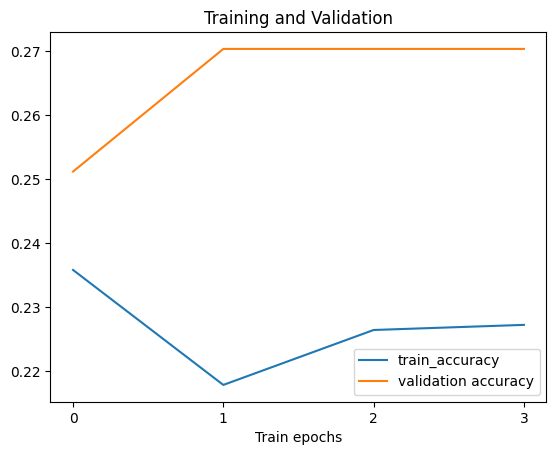

In [ ]:
num_epochs = early_stopping.stopped_epoch + 1

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.title('Training and Validation')
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(num_epochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()


In [ ]:
# evaluate the accuracy of model
train_accuracy = model1.evaluate(X_train, y_train, verbose=0)[1]
val_accuracy = model1.evaluate(X_val, y_val, verbose=0)[1]

print(f"\nTraining data accuracy: {train_accuracy:.2%}\nValidation data accuracy: {val_accuracy:.2%}")

test_accuracy = model1.evaluate(X_test, y_test, verbose=0)[1]
print(f"Test data accuracy: {test_accuracy:.2%}")


Training data accuracy: 23.22%
Validation data accuracy: 27.04%
Test data accuracy: 17.95%


## Model 2

In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model2 = tf.keras.Sequential()

# add convolutional layer 1
model2.add(layers.Conv2D(
        filters=128,
        kernel_size=(4, 4),
        strides = (1, 1),
        padding='same',
        data_format = 'channels_last',
        name = 'conv_1',
        activation='relu'))

# add max pooling layer 1
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add convolutional layer 2
model2.add(layers.Conv2D(
        filters=64,
        kernel_size=(4, 4),
        strides = (1, 1),
        padding='same',
        data_format = 'channels_last',
        name = 'conv_2',
        activation='relu'))

# add max pooling layer 2
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add dropout layer
model2.add(layers.Dropout(rate=0.3))

# add a flattening layer
model2.add(layers.Flatten())

# add a dense layer
model2.add(layers.Dense(512, activation='relu'))

# add the classification layer
model2.add(layers.Dense(4, activation='softmax'))

# build and compile model
model2.build(input_shape=(None, width, height, 3))
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# print model summary
model2.summary()

# train model on (X_train, y_train) data
history = model2.fit(
  x = X_train,
  y = y_train,
  epochs=20,
  class_weight=class_weights,
  validation_data=(X_val, y_val),
  callbacks=[early_stopping]
  )


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 128)  │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,694,404 (128.53 MB)

 Trainable params: 33,694,404 (128.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 52s 328ms/step - accuracy: 0.6731 - loss: 1.5275 - val_accuracy: 0.9736 - val_loss: 0.1162
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 52s 332ms/step - accuracy: 0.9454 - loss: 0.1557 - val_accuracy: 0.9706 - val_loss: 0.1260
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 53s 336ms/step - accuracy: 0.9420 - loss: 0.1935 - val_accuracy: 0.9898 - val_loss: 0.0404
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 348ms/step - accuracy: 0.9663 - loss: 0.1060 - val_accuracy: 0.9904 - val_loss: 0.0387
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 359ms/step - accuracy: 0.9799 - loss: 0.0605 - val_accuracy: 0.9886 - val_loss: 0.0520
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 356ms/step - accuracy: 0.9554 - loss: 0.1563 - val_accuracy: 0.9916 - val_loss: 0.0240
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 355ms/step - accuracy: 0.9821 - loss: 0.0577 - val_accuracy: 0.9946 - val_loss: 0.0266
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 348ms/step - accuracy: 0.9926 - loss: 0

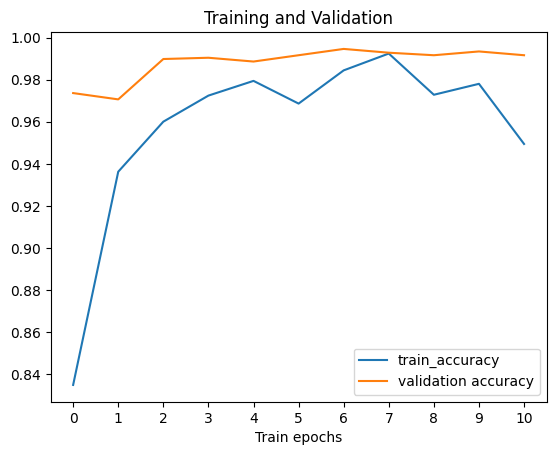

In [ ]:
num_epochs = early_stopping.stopped_epoch + 1

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.title('Training and Validation')
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(num_epochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()


In [ ]:
# evaluate the accuracy of model
train_accuracy = model2.evaluate(X_train, y_train, verbose=0)[1]
val_accuracy = model2.evaluate(X_val, y_val, verbose=0)[1]

print(f"\nTraining data accuracy: {train_accuracy:.2%}\nValidation data accuracy: {val_accuracy:.2%}")

test_accuracy = model2.evaluate(X_test, y_test, verbose=0)[1]
print(f"Test data accuracy: {test_accuracy:.2%}")


Training data accuracy: 99.42%
Validation data accuracy: 99.46%
Test data accuracy: 95.99%


## Model 3

In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model3 = tf.keras.Sequential()

# add convolutional layer 1
model3.add(layers.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding='same',
        data_format = 'channels_last',
        name = 'conv_1',
        activation='relu'))

# add max pooling layer 1
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add convolutional layer 2
model3.add(layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding='same',
        data_format = 'channels_last',
        name = 'conv_2',
        activation='relu'))

# add max pooling layer 2
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add convolutional layer 3
model3.add(layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding='same',
        data_format = 'channels_last',
        name = 'conv_3',
        activation='relu'))

# add max pooling layer 3
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add convolutional layer 4
model3.add(layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding='same',
        data_format = 'channels_last',
        name = 'conv_4',
        activation='relu'))

# add max pooling layer 4
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add dropout layer
model3.add(layers.Dropout(rate=0.3))

# add a flattening layer
model3.add(layers.Flatten())

# add a dense layer
model3.add(layers.Dense(512, activation='relu'))

# add the classification layer
model3.add(layers.Dense(4, activation='softmax'))

# build and compile model
model3.build(input_shape=(None, width, height, 3))
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# print model summary
model3.summary()

# train model on (X_train, y_train) data
history = model3.fit(
  x = X_train,
  y = y_train,
  epochs=20,
  class_weight=class_weights,
  validation_data=(X_val, y_val),
  callbacks=[early_stopping]
  )


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,183,908 (4.52 MB)

 Trainable params: 1,183,908 (4.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 219ms/step - accuracy: 0.2504 - loss: 13.7002 - val_accuracy: 0.2434 - val_loss: 1.3879
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 214ms/step - accuracy: 0.2495 - loss: 1.3801 - val_accuracy: 0.2704 - val_loss: 1.3869
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 215ms/step - accuracy: 0.2508 - loss: 1.3798 - val_accuracy: 0.2704 - val_loss: 1.3867
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.2494 - loss: 1.3798 - val_accuracy: 0.2704 - val_loss: 1.3867
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


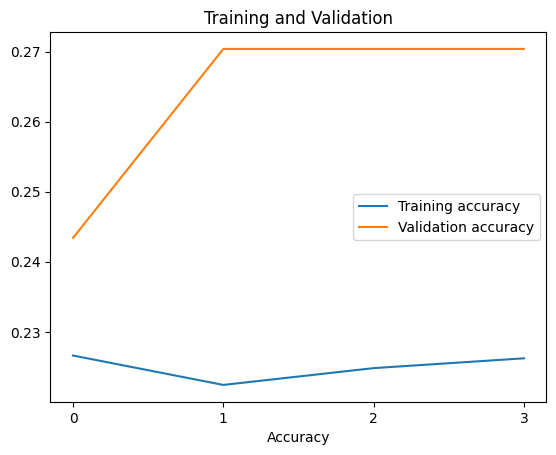

In [ ]:
num_epochs = early_stopping.stopped_epoch + 1

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.title('Training and Validation')
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.xticks(range(num_epochs))
plt.xlabel('Training epochs')
plt.xlabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# evaluate the accuracy of model
train_accuracy = model3.evaluate(X_train, y_train, verbose=0)[1]
val_accuracy = model3.evaluate(X_val, y_val, verbose=0)[1]

print(f"\nTraining data accuracy: {train_accuracy:.2%}\nValidation data accuracy: {val_accuracy:.2%}")

test_accuracy = model3.evaluate(X_test, y_test, verbose=0)[1]
print(f"Test data accuracy: {test_accuracy:.2%}")


Training data accuracy: 23.74%
Validation data accuracy: 24.34%
Test data accuracy: 18.25%


## Model 4

In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model4 = tf.keras.Sequential()

# add convolutional layer 1
model4.add(layers.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding='same',
        data_format = 'channels_last',
        name = 'conv_1',
        activation='relu'))

# add max pooling layer 1
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add convolutional layer 2
model4.add(layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding='same',
        data_format = 'channels_last',
        name = 'conv_2',
        activation='relu'))

# add max pooling layer 2
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add convolutional layer 3
model4.add(layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding='same',
        data_format = 'channels_last',
        name = 'conv_3',
        activation='relu'))

# add max pooling layer 3
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add convolutional layer 4
model4.add(layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding='same',
        data_format = 'channels_last',
        name = 'conv_4',
        activation='relu'))

# add max pooling layer 4
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add dropout layer
model4.add(layers.Dropout(rate=0.3))

# add a flattening layer
model4.add(layers.Flatten())

# add a dense layer
model4.add(layers.Dense(512, activation='relu'))

# add the classification layer
model4.add(layers.Dense(4, activation='softmax'))

# build and compile model
model4.build(input_shape=(None, width, height, 3))
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# print model summary
model4.summary()

# train model on (X_train, y_train) data
history = model4.fit(
  x = X_train,
  y = y_train,
  epochs=20,
  class_weight=class_weights,
  validation_data=(X_val, y_val),
  callbacks=[early_stopping]
  )


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,183,908 (4.52 MB)

 Trainable params: 1,183,908 (4.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - accuracy: 0.7043 - loss: 0.6419 - val_accuracy: 0.9898 - val_loss: 0.0494
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 221ms/step - accuracy: 0.9655 - loss: 0.1205 - val_accuracy: 0.9898 - val_loss: 0.0402
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - accuracy: 0.9812 - loss: 0.0598 - val_accuracy: 0.9820 - val_loss: 0.1006
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 216ms/step - accuracy: 0.9854 - loss: 0.0449 - val_accuracy: 0.9964 - val_loss: 0.0149
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 216ms/step - accuracy: 0.9819 - loss: 0.0581 - val_accuracy: 0.9982 - val_loss: 0.0085
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 217ms/step - accuracy: 0.9826 - loss: 0.0566 - val_accuracy: 1.0000 - val_loss: 7.4787e-04
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 214ms/step - accuracy: 0.9861 - loss: 0.0529 - val_accuracy: 0.9988 - val_loss: 0.0040
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 213ms/step - accuracy: 0.9968 - los

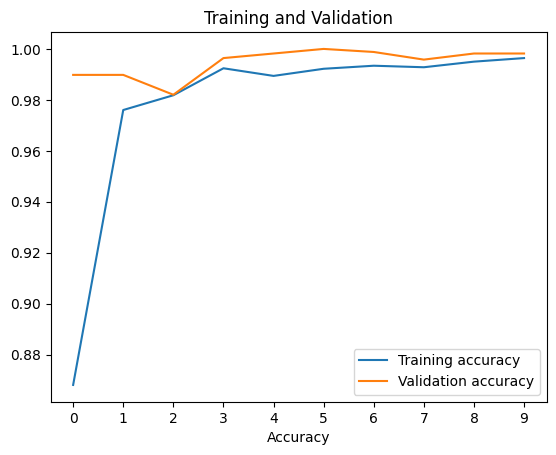

In [ ]:
num_epochs = early_stopping.stopped_epoch + 1

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.title('Training and Validation')
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.xticks(range(num_epochs))
plt.xlabel('Training epochs')
plt.xlabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# evaluate the accuracy of model
train_accuracy = model4.evaluate(X_train, y_train, verbose=0)[1]
val_accuracy = model4.evaluate(X_val, y_val, verbose=0)[1]

print(f"\nTraining data accuracy: {train_accuracy:.2%}\nValidation data accuracy: {val_accuracy:.2%}")

test_accuracy = model4.evaluate(X_test, y_test, verbose=0)[1]
print(f"Test data accuracy: {test_accuracy:.2%}")


Training data accuracy: 99.84%
Validation data accuracy: 100.00%
Test data accuracy: 96.99%
